In [1]:
import os
import json
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from collections import defaultdict

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Environment initialized successfully")

Environment initialized successfully


In [2]:
class Config:
    """Configuration class for the analysis pipeline."""
    
    BASE_PATH = Path("/kaggle/input/pancreatic-cancer-dataset/Task07_Pancreas/Task07_Pancreas")
    IMAGES_TRAIN_PATH = BASE_PATH / "imagesTr"
    LABELS_TRAIN_PATH = BASE_PATH / "labelsTr"
    IMAGES_TEST_PATH = BASE_PATH / "imagesTs"
    
    TUMOR_SIZE_THRESHOLDS = {'small': 20000, 'medium': 125000}
    FIGURE_SIZE = (15, 10)
    DPI = 100
    RANDOM_STATE = 42
    
    OUTPUT_DIR = Path("analysis_results")
    PLOTS_DIR = OUTPUT_DIR / "plots"
    DATA_DIR = OUTPUT_DIR / "processed_data"

class PancreaticDatasetAnalyzer:
    """Comprehensive analyzer for pancreatic cancer dataset."""
    
    def __init__(self, config: Config = None):
        self.config = config or Config()
        self.dataset_info = self._load_dataset_info()
        self.analysis_results = {}
        self.processed_data = []
        self._setup_directories()
    
    def _setup_directories(self) -> None:
        """Create necessary output directories."""
        for directory in [self.config.OUTPUT_DIR, self.config.PLOTS_DIR, self.config.DATA_DIR]:
            directory.mkdir(parents=True, exist_ok=True)
    
    def _load_dataset_info(self) -> Dict:
        """Load dataset configuration from dataset.json if available."""
        dataset_json_path = self.config.BASE_PATH / "dataset.json"
        
        if dataset_json_path.exists():
            try:
                with open(dataset_json_path, 'r') as f:
                    return json.load(f)
            except Exception as e:
                print(f"Warning: Could not load dataset.json: {e}")
        
        return {
            "description": "Pancreas segmentation dataset",
            "labels": {"0": "background", "1": "pancreas", "2": "tumor"},
            "modality": {"0": "CT"}
        }
    
    def _get_valid_files(self, directory: Path, extensions: List[str] = [".nii", ".nii.gz"]) -> List[Path]:
        """Get list of valid NIfTI files from directory."""
        if not directory.exists():
            return []
        
        valid_files = []
        for file_path in directory.iterdir():
            if (any(file_path.name.endswith(ext) for ext in extensions) and 
                not file_path.name.startswith('._') and 
                file_path.stat().st_size > 1024):
                valid_files.append(file_path)
        
        return sorted(valid_files)
    
    def _find_matching_file(self, base_name: str, file_list: List[Path]) -> Optional[Path]:
        """Find matching file based on base name."""
        for file_path in file_list:
            file_base = file_path.stem.replace('.nii', '').replace('.gz', '')
            if base_name == file_base:
                return file_path
        return None
    
    def _classify_tumor_size(self, volume_mm3: float) -> str:
        """Classify tumor size based on volume thresholds."""
        if volume_mm3 < self.config.TUMOR_SIZE_THRESHOLDS['small']:
            return 'small'
        elif volume_mm3 < self.config.TUMOR_SIZE_THRESHOLDS['medium']:
            return 'medium'
        else:
            return 'large'
    
    def _analyze_nifti_file(self, file_path: Path, is_label: bool = False) -> Optional[Dict]:
        """Analyze a single NIfTI file and extract relevant metrics."""
        try:
            nii_image = nib.load(str(file_path))
            data = nii_image.get_fdata()
            
            if data.size == 0:
                return None
            
            voxel_size = nii_image.header.get_zooms()[:3]
            voxel_volume = np.prod(voxel_size)
            
            analysis = {
                'filename': file_path.name,
                'shape': data.shape,
                'voxel_size_mm': voxel_size,
                'voxel_volume_mm3': voxel_volume,
                'data_type': str(data.dtype),
                'total_voxels': int(data.size),
                'physical_volume_cm3': float((voxel_volume * data.size) / 1000)
            }
            
            if not is_label:
                analysis.update({
                    'intensity_min': float(np.min(data)),
                    'intensity_max': float(np.max(data)),
                    'intensity_mean': float(np.mean(data)),
                    'intensity_std': float(np.std(data)),
                    'non_zero_voxels': int(np.count_nonzero(data))
                })
            else:
                unique_labels = np.unique(data)
                analysis['unique_labels'] = unique_labels.tolist()
                analysis['label_volumes'] = {}
                
                for label in unique_labels:
                    label_voxels = int(np.sum(data == label))
                    label_volume_mm3 = float(label_voxels * voxel_volume)
                    
                    analysis['label_volumes'][int(label)] = {
                        'voxel_count': label_voxels,
                        'volume_mm3': label_volume_mm3,
                        'volume_cm3': label_volume_mm3 / 1000,
                        'percentage': float((label_voxels / data.size) * 100)
                    }
                
                analysis['has_tumor'] = 2 in unique_labels
                if analysis['has_tumor']:
                    tumor_volume = analysis['label_volumes'][2]['volume_mm3']
                    analysis['tumor_size_class'] = self._classify_tumor_size(tumor_volume)
                else:
                    analysis['tumor_size_class'] = 'no_tumor'
            
            return analysis
            
        except Exception as e:
            print(f"Error analyzing {file_path}: {e}")
            return None
    
    def process_dataset(self, batch_size: int = 20) -> None:
        """Process the entire dataset and extract analysis metrics."""
        print("Starting dataset processing...")
        
        image_files = self._get_valid_files(self.config.IMAGES_TRAIN_PATH)
        label_files = self._get_valid_files(self.config.LABELS_TRAIN_PATH)
        
        print(f"Found {len(image_files)} image files and {len(label_files)} label files")
        
        if len(image_files) == 0:
            raise ValueError("No valid image files found. Please check the dataset path.")
        
        total_files = len(image_files)
        total_batches = (total_files + batch_size - 1) // batch_size
        
        for batch_idx in range(0, total_files, batch_size):
            batch_files = image_files[batch_idx:batch_idx + batch_size]
            current_batch = (batch_idx // batch_size) + 1
            
            print(f"Processing batch {current_batch}/{total_batches}")
            
            for img_file in batch_files:
                img_base = img_file.stem.replace('.nii', '').replace('.gz', '')
                label_file = self._find_matching_file(img_base, label_files)
                
                img_analysis = self._analyze_nifti_file(img_file, is_label=False)
                if img_analysis is None:
                    continue
                
                case_data = {
                    'case_id': img_base,
                    'image_file': img_file.name,
                    'image_analysis': img_analysis
                }
                
                if label_file:
                    label_analysis = self._analyze_nifti_file(label_file, is_label=True)
                    if label_analysis:
                        case_data.update({
                            'label_file': label_file.name,
                            'label_analysis': label_analysis,
                            'has_tumor': label_analysis['has_tumor'],
                            'tumor_size_class': label_analysis['tumor_size_class']
                        })
                    else:
                        case_data.update({'has_tumor': False, 'tumor_size_class': 'unknown'})
                else:
                    case_data.update({'has_tumor': False, 'tumor_size_class': 'no_label'})
                
                self.processed_data.append(case_data)
        
        print(f"Dataset processing complete: {len(self.processed_data)} cases analyzed")
    
    def create_dataframe(self) -> pd.DataFrame:
        """Convert processed data to pandas DataFrame for analysis."""
        if not self.processed_data:
            raise ValueError("No processed data available. Run process_dataset() first.")
        
        rows = []
        
        for case in self.processed_data:
            row = {
                'case_id': case['case_id'],
                'image_file': case['image_file'],
                'has_tumor': case['has_tumor'],
                'tumor_size_class': case['tumor_size_class']
            }
            
            img_analysis = case['image_analysis']
            row.update({
                'image_shape_x': img_analysis['shape'][0],
                'image_shape_y': img_analysis['shape'][1],
                'image_shape_z': img_analysis['shape'][2],
                'voxel_size_x': img_analysis['voxel_size_mm'][0],
                'voxel_size_y': img_analysis['voxel_size_mm'][1],
                'voxel_size_z': img_analysis['voxel_size_mm'][2],
                'physical_volume_cm3': img_analysis['physical_volume_cm3'],
                'intensity_mean': img_analysis.get('intensity_mean', np.nan),
                'intensity_std': img_analysis.get('intensity_std', np.nan)
            })
            
            if 'label_analysis' in case and case['label_analysis']:
                label_analysis = case['label_analysis']
                
                if 2 in label_analysis['label_volumes']:
                    tumor_info = label_analysis['label_volumes'][2]
                    row.update({
                        'tumor_volume_mm3': tumor_info['volume_mm3'],
                        'tumor_volume_cm3': tumor_info['volume_cm3'],
                        'tumor_percentage': tumor_info['percentage']
                    })
                else:
                    row.update({
                        'tumor_volume_mm3': 0.0,
                        'tumor_volume_cm3': 0.0,
                        'tumor_percentage': 0.0
                    })
                
                if 1 in label_analysis['label_volumes']:
                    pancreas_info = label_analysis['label_volumes'][1]
                    row.update({
                        'pancreas_volume_mm3': pancreas_info['volume_mm3'],
                        'pancreas_volume_cm3': pancreas_info['volume_cm3'],
                        'pancreas_percentage': pancreas_info['percentage']
                    })
                    
                    if row['tumor_volume_mm3'] > 0:
                        row['tumor_to_pancreas_ratio'] = row['tumor_volume_mm3'] / pancreas_info['volume_mm3']
                    else:
                        row['tumor_to_pancreas_ratio'] = 0.0
                else:
                    row.update({
                        'pancreas_volume_mm3': np.nan,
                        'pancreas_volume_cm3': np.nan,
                        'pancreas_percentage': np.nan,
                        'tumor_to_pancreas_ratio': np.nan
                    })
            else:
                for col in ['tumor_volume_mm3', 'tumor_volume_cm3', 'tumor_percentage',
                           'pancreas_volume_mm3', 'pancreas_volume_cm3', 'pancreas_percentage',
                           'tumor_to_pancreas_ratio']:
                    row[col] = np.nan
            
            rows.append(row)
        
        return pd.DataFrame(rows)
    
    def generate_statistics(self, df: pd.DataFrame) -> Dict:
        """Generate comprehensive statistics from the dataset."""
        stats = {
            'total_cases': len(df),
            'cases_with_tumor': int(df['has_tumor'].sum()),
        }
        stats['tumor_prevalence_percent'] = float((stats['cases_with_tumor'] / stats['total_cases']) * 100)
        
        stats['size_class_distribution'] = df['tumor_size_class'].value_counts().to_dict()
        size_percentages = df['tumor_size_class'].value_counts(normalize=True) * 100
        stats['size_class_percentages'] = size_percentages.to_dict()
        
        tumor_cases = df[df['has_tumor'] == True]
        if len(tumor_cases) > 0:
            tumor_volumes = tumor_cases['tumor_volume_mm3'].dropna()
            stats['tumor_volume_stats'] = {
                'count': int(len(tumor_volumes)),
                'mean': float(tumor_volumes.mean()),
                'median': float(tumor_volumes.median()),
                'std': float(tumor_volumes.std()),
                'min': float(tumor_volumes.min()),
                'max': float(tumor_volumes.max()),
                'percentiles': {
                    '25th': float(np.percentile(tumor_volumes, 25)),
                    '75th': float(np.percentile(tumor_volumes, 75)),
                    '90th': float(np.percentile(tumor_volumes, 90)),
                    '95th': float(np.percentile(tumor_volumes, 95)),
                    '99th': float(np.percentile(tumor_volumes, 99))
                }
            }
        
        stats['image_dimensions'] = {
            'mean_shape': [
                float(df['image_shape_x'].mean()),
                float(df['image_shape_y'].mean()),
                float(df['image_shape_z'].mean())
            ],
            'mean_voxel_size': [
                float(df['voxel_size_x'].mean()),
                float(df['voxel_size_y'].mean()),
                float(df['voxel_size_z'].mean())
            ],
            'mean_physical_volume_cm3': float(df['physical_volume_cm3'].mean())
        }
        
        return stats
    
    def create_visualizations(self, df: pd.DataFrame, stats: Dict) -> plt.Figure:
        """Create comprehensive visualization plots."""
        fig, axes = plt.subplots(2, 3, figsize=self.config.FIGURE_SIZE, dpi=self.config.DPI)
        fig.suptitle('Pancreatic Cancer Dataset Analysis', fontsize=16, y=0.98)
        
        # Size class distribution
        size_counts = df['tumor_size_class'].value_counts()
        axes[0, 0].pie(size_counts.values, labels=size_counts.index, autopct='%1.1f%%', startangle=90)
        axes[0, 0].set_title('Tumor Size Class Distribution')
        
        # Tumor presence
        tumor_counts = df['has_tumor'].value_counts()
        labels = ['No Tumor', 'Has Tumor']
        counts = [tumor_counts.get(False, 0), tumor_counts.get(True, 0)]
        axes[0, 1].bar(labels, counts, color=['lightcoral', 'lightblue'])
        axes[0, 1].set_title('Cases with/without Tumor')
        axes[0, 1].set_ylabel('Number of Cases')
        
        # Tumor volume distribution
        tumor_cases = df[df['has_tumor'] == True]
        if len(tumor_cases) > 0:
            tumor_volumes = tumor_cases['tumor_volume_mm3'].dropna()
            axes[0, 2].hist(tumor_volumes, bins=30, alpha=0.7, edgecolor='black')
            axes[0, 2].set_title('Tumor Volume Distribution')
            axes[0, 2].set_xlabel('Volume (mm³)')
            axes[0, 2].set_ylabel('Frequency')
            axes[0, 2].axvline(self.config.TUMOR_SIZE_THRESHOLDS['small'], 
                              color='red', linestyle='--', label='Small-Medium')
            axes[0, 2].axvline(self.config.TUMOR_SIZE_THRESHOLDS['medium'], 
                              color='orange', linestyle='--', label='Medium-Large')
            axes[0, 2].legend()
        
        # Image dimensions
        axes[1, 0].scatter(df['image_shape_x'], df['image_shape_y'], alpha=0.6)
        axes[1, 0].set_title('Image Dimensions (X vs Y)')
        axes[1, 0].set_xlabel('Width (voxels)')
        axes[1, 0].set_ylabel('Height (voxels)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Voxel size distribution
        voxel_data = df[['voxel_size_x', 'voxel_size_y', 'voxel_size_z']].dropna()
        if not voxel_data.empty:
            voxel_data.boxplot(ax=axes[1, 1])
            axes[1, 1].set_title('Voxel Size Distribution')
            axes[1, 1].set_ylabel('Size (mm)')
        
        # Volume correlation
        if len(tumor_cases) > 0:
            valid_data = tumor_cases[['physical_volume_cm3', 'tumor_volume_mm3']].dropna()
            if not valid_data.empty:
                axes[1, 2].scatter(valid_data['physical_volume_cm3'], 
                                  valid_data['tumor_volume_mm3'], alpha=0.6)
                axes[1, 2].set_title('Total vs Tumor Volume')
                axes[1, 2].set_xlabel('Total Volume (cm³)')
                axes[1, 2].set_ylabel('Tumor Volume (mm³)')
                axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def print_summary(self, stats: Dict) -> None:
        """Print comprehensive summary statistics."""
        print("\nPANCREATIC CANCER DATASET ANALYSIS SUMMARY")
        print("=" * 60)
        
        print(f"\nDataset Overview:")
        print(f"  Total cases analyzed: {stats['total_cases']}")
        print(f"  Cases with tumor: {stats['cases_with_tumor']} ({stats['tumor_prevalence_percent']:.1f}%)")
        
        print(f"\nSize Class Distribution:")
        for size_class, count in stats['size_class_distribution'].items():
            percentage = stats['size_class_percentages'][size_class]
            print(f"  {size_class.capitalize()}: {count} cases ({percentage:.1f}%)")
        
        if 'tumor_volume_stats' in stats:
            tvs = stats['tumor_volume_stats']
            print(f"\nTumor Volume Statistics (cases with tumors):")
            print(f"  Count: {tvs['count']}")
            print(f"  Mean ± SD: {tvs['mean']:.0f} ± {tvs['std']:.0f} mm³")
            print(f"  Median: {tvs['median']:.0f} mm³")
            print(f"  Range: {tvs['min']:.0f} - {tvs['max']:.0f} mm³")
            print(f"  90th percentile: {tvs['percentiles']['90th']:.0f} mm³")
            print(f"  95th percentile: {tvs['percentiles']['95th']:.0f} mm³")
        
        dims = stats['image_dimensions']
        print(f"\nImage Characteristics:")
        print(f"  Average dimensions: {dims['mean_shape'][0]:.0f} × {dims['mean_shape'][1]:.0f} × {dims['mean_shape'][2]:.0f}")
        print(f"  Average voxel size: {dims['mean_voxel_size'][0]:.2f} × {dims['mean_voxel_size'][1]:.2f} × {dims['mean_voxel_size'][2]:.2f} mm")
        print(f"  Average physical volume: {dims['mean_physical_volume_cm3']:.0f} cm³")
    
    def save_results(self, df: pd.DataFrame, stats: Dict, fig: plt.Figure) -> None:
        """Save analysis results to files."""
        csv_path = self.config.DATA_DIR / "pancreas_analysis_results.csv"
        df.to_csv(csv_path, index=False)
        print(f"Results saved to: {csv_path}")
        
        stats_path = self.config.DATA_DIR / "analysis_statistics.json"
        with open(stats_path, 'w') as f:
            json.dump(stats, f, indent=2, default=str)
        print(f"Statistics saved to: {stats_path}")
        
        plot_path = self.config.PLOTS_DIR / "dataset_analysis.png"
        fig.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Visualization saved to: {plot_path}")
    
    def run_complete_analysis(self) -> Tuple[pd.DataFrame, Dict]:
        """Execute the complete analysis pipeline."""
        print("Initializing comprehensive pancreatic cancer dataset analysis...")
        
        self.process_dataset()
        df = self.create_dataframe()
        stats = self.generate_statistics(df)
        fig = self.create_visualizations(df, stats)
        self.print_summary(stats)
        self.save_results(df, stats, fig)
        plt.show()
        
        return df, stats

print("Class definition completed successfully")

Class definition completed successfully


Initializing comprehensive pancreatic cancer dataset analysis...
Starting dataset processing...
Found 281 image files and 281 label files
Processing batch 1/15
Processing batch 2/15
Processing batch 3/15
Processing batch 4/15
Processing batch 5/15
Processing batch 6/15
Processing batch 7/15
Processing batch 8/15
Processing batch 9/15
Processing batch 10/15
Processing batch 11/15
Processing batch 12/15
Processing batch 13/15
Processing batch 14/15
Processing batch 15/15
Dataset processing complete: 281 cases analyzed

PANCREATIC CANCER DATASET ANALYSIS SUMMARY

Dataset Overview:
  Total cases analyzed: 281
  Cases with tumor: 281 (100.0%)

Size Class Distribution:
  Small: 255 cases (90.7%)
  Medium: 22 cases (7.8%)
  Large: 4 cases (1.4%)

Tumor Volume Statistics (cases with tumors):
  Count: 281
  Mean ± SD: 12937 ± 46719 mm³
  Median: 5778 mm³
  Range: 413 - 732388 mm³
  90th percentile: 18901 mm³
  95th percentile: 38901 mm³

Image Characteristics:
  Average dimensions: 512 × 512 × 

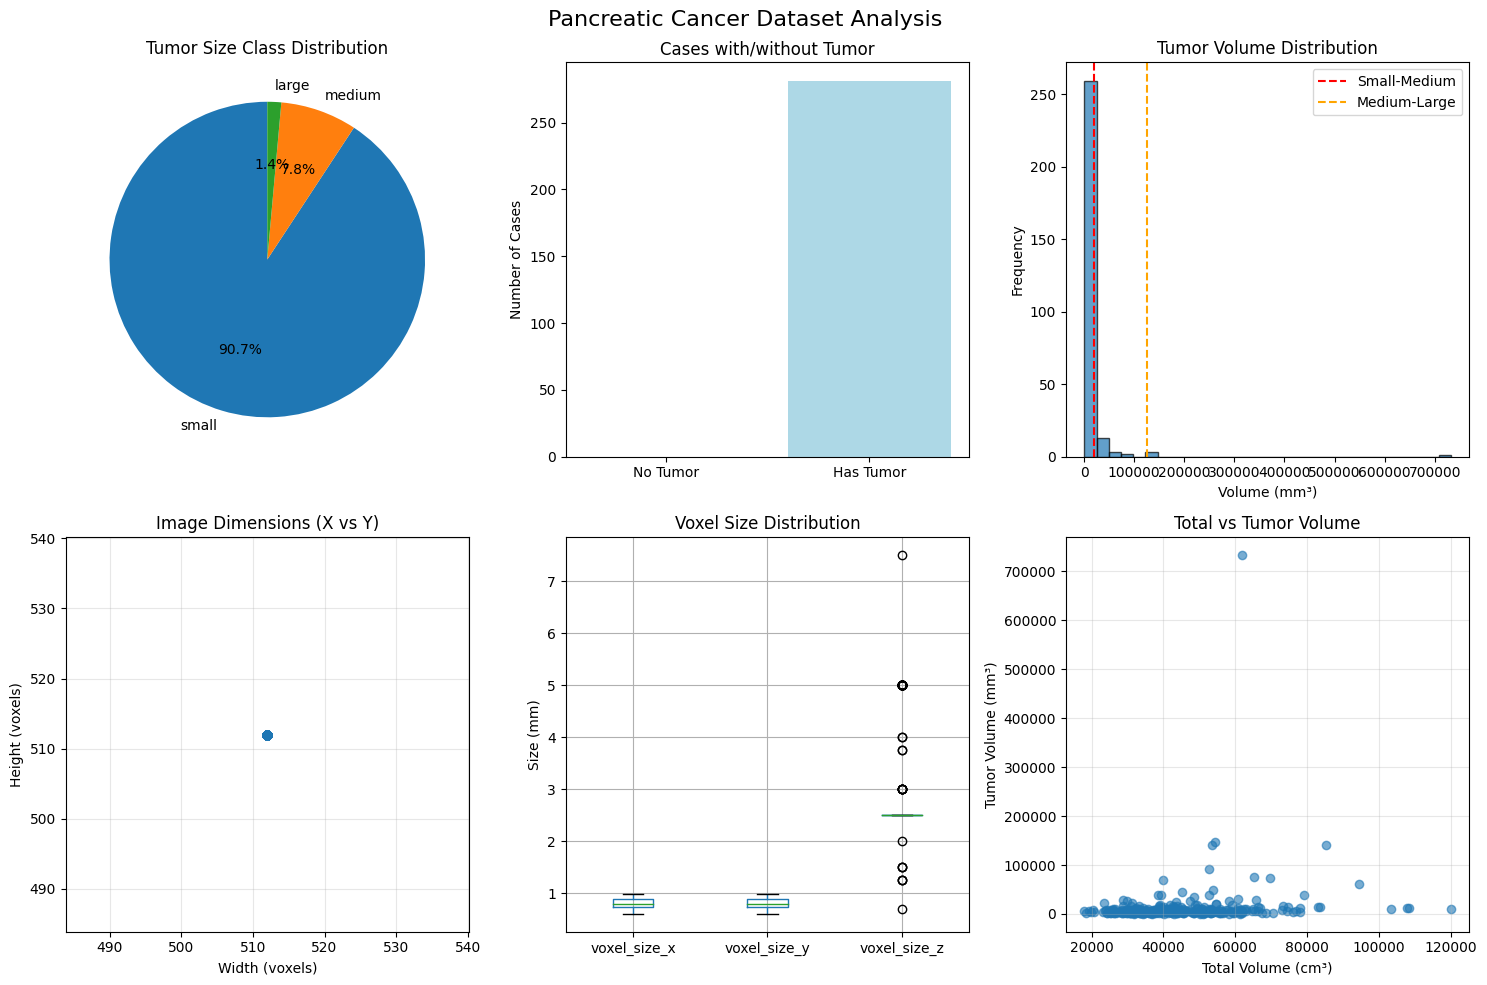


Analysis completed successfully!
DataFrame shape: (281, 20)
Available columns: ['case_id', 'image_file', 'has_tumor', 'tumor_size_class', 'image_shape_x', 'image_shape_y', 'image_shape_z', 'voxel_size_x', 'voxel_size_y', 'voxel_size_z', 'physical_volume_cm3', 'intensity_mean', 'intensity_std', 'tumor_volume_mm3', 'tumor_volume_cm3', 'tumor_percentage', 'pancreas_volume_mm3', 'pancreas_volume_cm3', 'pancreas_percentage', 'tumor_to_pancreas_ratio']


In [3]:
def main():
    """Main function to run the analysis."""
    try:
        analyzer = PancreaticDatasetAnalyzer()
        df, stats = analyzer.run_complete_analysis()
        
        print("\nAnalysis completed successfully!")
        print(f"DataFrame shape: {df.shape}")
        print(f"Available columns: {list(df.columns)}")
        
        return df, stats
        
    except Exception as e:
        print(f"Analysis failed with error: {e}")
        raise

# Execute the analysis
results_df, analysis_stats = main()

In [4]:
# Display first few rows
print("First 5 rows of analysis results:")
display(results_df.head())

# Show basic info
print("\nDataFrame Info:")
results_df.info()

# Show size distribution
print("\nTumor Size Class Distribution:")
print(results_df['tumor_size_class'].value_counts())

First 5 rows of analysis results:


,case_id,image_file,has_tumor,tumor_size_class,image_shape_x,image_shape_y,image_shape_z,voxel_size_x,voxel_size_y,voxel_size_z,physical_volume_cm3,intensity_mean,intensity_std,tumor_volume_mm3,tumor_volume_cm3,tumor_percentage,pancreas_volume_mm3,pancreas_volume_cm3,pancreas_percentage,tumor_to_pancreas_ratio
0,pancreas_001,pancreas_001.nii,True,medium,512,512,110,0.644531,0.644531,2.5,29947.479375,-450.009910,497.018480,27161.214242,27.161214,0.090696,41081.946690,41.081947,0.137180,0.661147
1,pancreas_004,pancreas_004.nii,True,medium,512,512,107,0.742188,0.742188,2.5,38627.050156,-503.111402,506.422214,39175.954189,39.175954,0.101421,98631.193439,98.631193,0.255342,0.397196
2,pancreas_005,pancreas_005.nii,True,small,512,512,104,0.917969,0.917969,2.5,57434.026000,-623.373424,488.576016,7602.963075,7.602963,0.013238,149704.007208,149.704007,0.260654,0.050787
3,pancreas_006,pancreas_006.nii,True,small,512,512,101,0.767578,0.767578,2.5,38998.359875,-579.820920,494.325853,13615.857065,13.615857,0.034914,103173.553006,103.173553,0.264559,0.131970
4,pancreas_010,pancreas_010.nii,True,medium,512,512,174,0.976562,0.976562,1.5,65249.934750,-514.041645,494.467457,76093.120776,76.093121,0.116618,166641.545547,166.641546,0.255390,0.456628



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   case_id                  281 non-null    object 
 1   image_file               281 non-null    object 
 2   has_tumor                281 non-null    bool   
 3   tumor_size_class         281 non-null    object 
 4   image_shape_x            281 non-null    int64  
 5   image_shape_y            281 non-null    int64  
 6   image_shape_z            281 non-null    int64  
 7   voxel_size_x             281 non-null    float32
 8   voxel_size_y             281 non-null    float32
 9   voxel_size_z             281 non-null    float32
 10  physical_volume_cm3      281 non-null    float64
 11  intensity_mean           281 non-null    float64
 12  intensity_std            281 non-null    float64
 13  tumor_volume_mm3         281 non-null    float64
 14  tumor_vol

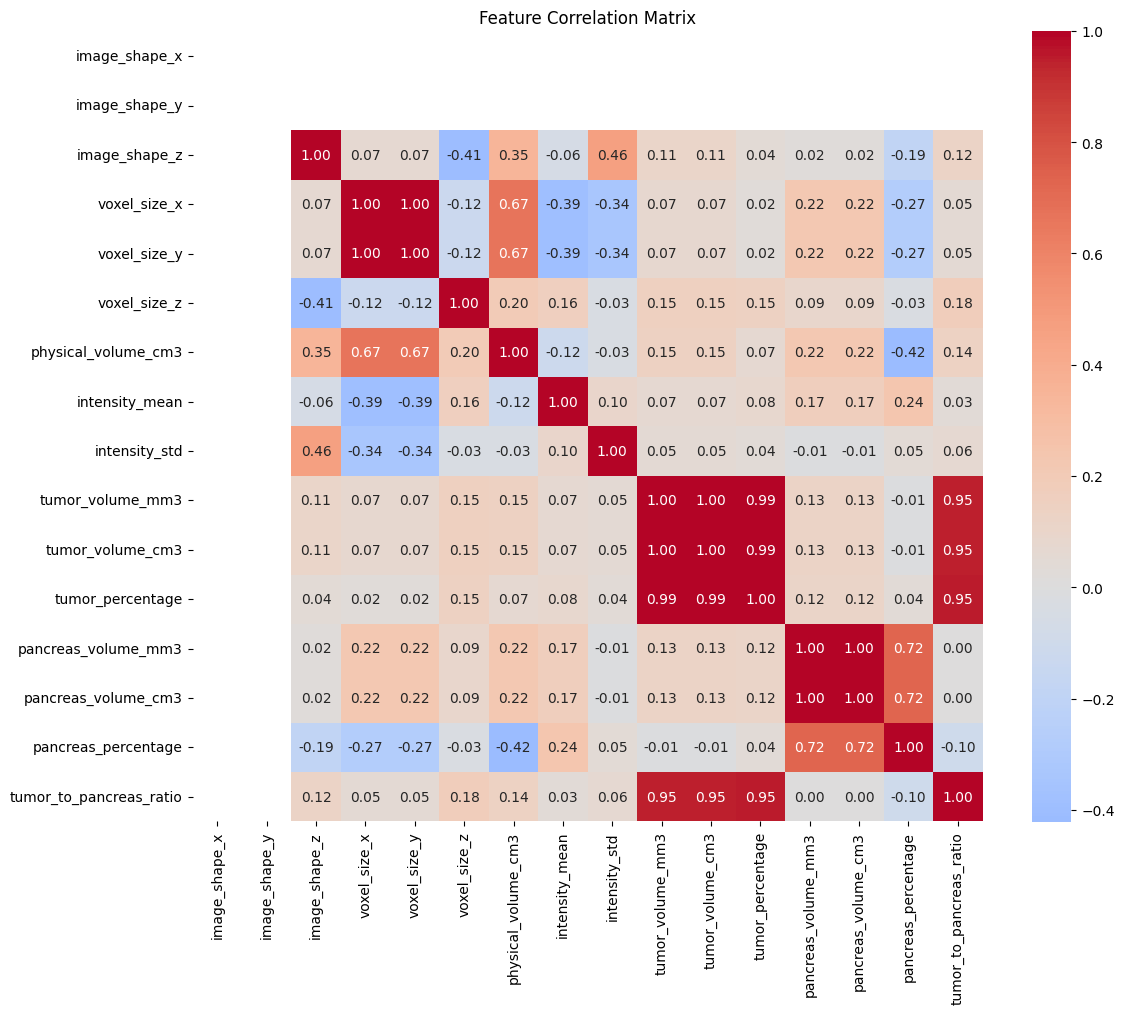

Summary statistics for numeric columns:


,image_shape_x,image_shape_y,image_shape_z,voxel_size_x,voxel_size_y,voxel_size_z,physical_volume_cm3,intensity_mean,intensity_std,tumor_volume_mm3,tumor_volume_cm3,tumor_percentage,pancreas_volume_mm3,pancreas_volume_cm3,pancreas_percentage,tumor_to_pancreas_ratio
count,281.0,281.0,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,512.0,512.0,95.085409,0.812373,0.812373,2.900178,45065.769765,-572.874693,490.417013,12937.070012,12.937070,0.026805,82799.211499,82.799211,0.199549,0.155953
std,0.0,0.0,48.470976,0.094261,0.094261,0.980711,16145.865358,67.904275,36.791290,46718.547456,46.718547,0.076693,35896.473891,35.896474,0.105075,0.399077
min,512.0,512.0,37.000000,0.605469,0.605469,0.700012,17993.756313,-761.298313,425.757020,412.882058,0.412882,0.001299,20282.558743,20.282559,0.046424,0.006024
25%,512.0,512.0,83.000000,0.740234,0.740234,2.500000,33396.500531,-615.421722,477.397313,2775.010365,2.775010,0.006718,57259.643555,57.259644,0.124311,0.038752
50%,512.0,512.0,93.000000,0.802734,0.802734,2.500000,42590.326500,-564.362359,488.264462,5778.495624,5.778496,0.013061,77029.418945,77.029419,0.177765,0.075724
75%,512.0,512.0,103.000000,0.892578,0.892578,2.500000,53422.222188,-531.019608,498.917039,10272.807218,10.272807,0.025681,104168.068582,104.168069,0.246393,0.131265
max,512.0,512.0,751.000000,0.976562,0.976562,7.500000,119999.880000,-367.143940,811.796864,732388.137200,732.388137,1.185814,201444.340425,201.444340,0.723422,5.416660


In [5]:
# Correlation analysis
numeric_cols = results_df.select_dtypes(include=[np.number]).columns
correlation_matrix = results_df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Summary statistics
print("Summary statistics for numeric columns:")
display(results_df[numeric_cols].describe())